In [188]:
import pathlib
import pandas as pd
from dtv_backend.lock import Locks

In [4]:
df_met_afzetting = pd.read_csv('plots_routes/locks_with_afzetting_.csv', parse_dates=['Timestamp'])
df_zonder_afzetting = pd.read_csv('plots_routes/locks_without_afzetting_.csv', parse_dates=['Timestamp'])


In [189]:
locks_gdf = Locks(env=None).locks_gdf
locks_gdf_dict = locks_gdf.set_index('Id')['Name'].to_dict()

In [190]:
queues_met_afzetting = df_met_afzetting[['name', 'queue_a', 'queue_b']].groupby('name').max()
queues_zonder_afzetting = df_zonder_afzetting[['name', 'queue_a', 'queue_b']].groupby('name').max()
queues_all = pd.concat([queues_met_afzetting, queues_zonder_afzetting], axis=1, keys=['met_afzetting', 'zonder_afzetting']).sort_values(by=[('met_afzetting', 'queue_a'), ('met_afzetting', 'queue_b')], ascending=False).head(10)
queues_all.index = [queues_all.index, queues_all.index.map(locks_gdf_dict)]
queues_all.index.names = ['id', 'name']
queues_all

met_afzetting         zonder_afzetting  \
                                             queue_a queue_b          queue_a   
id      name                                                                    
7069311 Doorslagsluis                           52.0     1.0             10.0   
50750   Oranjesluizen                           46.0    21.0              1.0   
33285   Zeeburgerschutsluis                     30.0     2.0              0.0   
1306537 Royerssluis                             28.0     3.0              3.0   
22179   sluis Maasbracht                        17.0     2.0              1.0   
7070374 sluis 13                                16.0     1.0              0.0   
24504   sluis St. Andries                        8.0     8.0              1.0   
7804    Julianasluis                             7.0     2.0              NaN   
55845   Nieuwe Meerschutsluis (SL 109)           7.0     2.0              2.0   
42863   Volkeraksluizen                          6.0     5.0              2.0   

                                                
                                       queue_b  
id      name                                    
7069311 Doorslagsluis                      2.0  
50750   Oranjesluizen                      2.0  
33285   Zeeburgerschutsluis                1.0  
1306537 Royerssluis                        0.0  
22179   sluis Maasbracht                   1.0  
7070374 sluis 13                           1.0  
24504   sluis St. Andries                  3.0  
7804    Julianasluis                       NaN  
55845   Nieuwe Meerschutsluis (SL 109)     1.0  
42863   Volkeraksluizen                    2.0

D:\Users\ALPF\AppData\Local\Temp\ipykernel_24104\1015055899.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

D:\Users\ALPF\AppData\Local\Temp\ipykernel_24104\1015055899.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Text(0.5, 0.98, 'Wachtrij lengte bij Doorslagsluis')

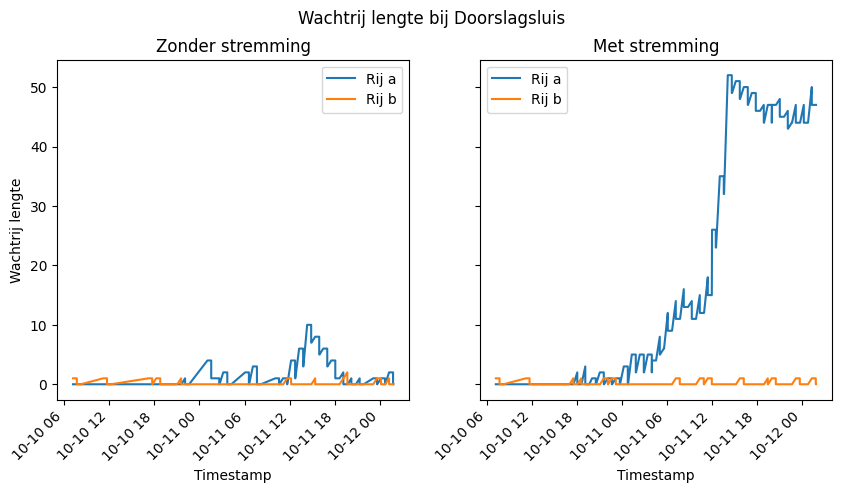

In [196]:
import matplotlib.pyplot as plt
lock = 7069311
df_met_afzetting_lock = df_met_afzetting[df_met_afzetting['name']==lock].set_index('Timestamp')
df_zonder_afzetting_lock = df_zonder_afzetting[df_zonder_afzetting['name']==lock].set_index('Timestamp')
fig, axs=plt.subplots(1, 2, figsize=(10, 5), sharey=True)
df_met_afzetting_lock.plot(y=['queue_a', 'queue_b'], ax=axs[1], title='Met stremming')
axs[1].legend(['Rij a', 'Rij b'])
df_zonder_afzetting_lock.plot(y=['queue_a', 'queue_b'], ax=axs[0], title='Zonder stremming')
axs[0].legend(['Rij a', 'Rij b'])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
axs[0].set_ylabel('Wachtrij lengte')
fig.suptitle('Wachtrij lengte bij {}'.format(locks_gdf_dict[lock]))
# round xlabel times to nearest hour
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

In [127]:
import geopandas as gpd

vessels_log_without_afzetting = gpd.read_file('plots_routes/trajectories_without_afzetting.gpkg')
vessels_log_with_afzetting = gpd.read_file('plots_routes/trajectories_with_afzetting.gpkg')


In [176]:
vessels_log_without_afzetting['t'] = pd.to_datetime(vessels_log_without_afzetting['t'], format='ISO8601', yearfirst=True)
vessels_log_with_afzetting['t'] = pd.to_datetime(vessels_log_with_afzetting['t'], format='ISO8601', yearfirst=True)
grouped_with_afzetting = vessels_log_with_afzetting.groupby('object_id')['t'].agg(['max', 'min'])
grouped_with_afzetting['time'] = grouped_with_afzetting['max'] - grouped_with_afzetting['min']
grouped_without_afzetting = vessels_log_without_afzetting.groupby('object_id')['t'].agg(['max', 'min'])
grouped_without_afzetting['time'] = grouped_without_afzetting['max'] - grouped_without_afzetting['min']
vessel_times_df = pd.concat([grouped_with_afzetting, grouped_without_afzetting], axis=1, keys=['met_afzetting', 'zonder_afzetting']).dropna()
vessel_times_df['difference (h)'] = (vessel_times_df[('met_afzetting', 'time')] - vessel_times_df[('zonder_afzetting', 'time')]).dt.total_seconds()/60/60

In [177]:
vessel_times_df.to_csv('plots_routes/vessel_times.csv')

<Axes: title={'center': 'Extra vaartijd door stremming'}, ylabel='Frequency'>

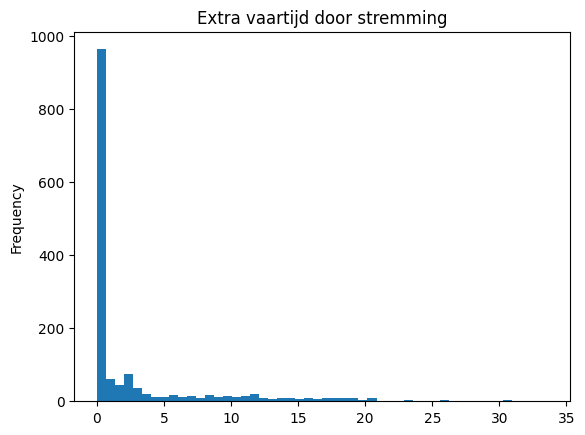

In [182]:
abs(vessel_times_df['difference (h)']).plot(kind='hist', bins=50, title='Extra vaartijd door stremming')

In [6]:
import os
from moviepy.editor import * 
image_folder_without_afzetting=r'D:\Users\ALPF\Documents\projecten\Digital twin vaarwegen\digitaltwin-waterway\dtv_backend\plots_routes\trajectories without afzetting'
image_folder_with_afzetting=r'D:\Users\ALPF\Documents\projecten\Digital twin vaarwegen\digitaltwin-waterway\dtv_backend\plots_routes\trajectories with afzetting'

fps=13

image_files_without_afzetting = [os.path.join(image_folder_without_afzetting,img)
               for img in os.listdir(image_folder_without_afzetting)
               if img.endswith(".png")]

image_files_with_afzetting = [os.path.join(image_folder_with_afzetting,img)
               for img in os.listdir(image_folder_with_afzetting)
               if img.endswith(".png")]
               
clip_without_afzetting = ImageSequenceClip(image_files_without_afzetting, fps=fps)
clip_with_afzetting = ImageSequenceClip(image_files_with_afzetting, fps=fps)

clip_without_afzetting.write_videofile(r'D:\Users\ALPF\Documents\projecten\Digital twin vaarwegen\digitaltwin-waterway\dtv_backend\plots_routes\video_without_afzetting.mp4')
clip_with_afzetting.write_videofile(r'D:\Users\ALPF\Documents\projecten\Digital twin vaarwegen\digitaltwin-waterway\dtv_backend\plots_routes\video_with_afzetting.mp4')
#clip.ipython_display(width = 360)  


Moviepy - Building video plots_routesideo_without_afzetting.mp4.
Moviepy - Writing video plots_routesideo_without_afzetting.mp4



t:   0%|          | 0/288 [00:00<?, ?it/s, now=None]

OSError: [Errno 22] Invalid argument

MoviePy error: FFMPEG encountered the following error while writing file plots_routesideo_without_afzetting.mp4:

 b'plots_routes\x0bideo_without_afzetting.mp4: Invalid argument\r\n'